In [1]:

# Dataset setup mirroring `scripts/eval_benchmarks.py`
import sys
from pathlib import Path
import random
import numpy as np
import torch
from torch.utils.data import DataLoader


def _resolve_project_root():
    candidates = []
    try:
        candidates.append(Path.cwd().resolve())
    except FileNotFoundError:
        candidates.append(None)
    if "__file__" in globals():
        candidates.append(Path(__file__).resolve().parent)
    candidates.append(Path("/home/bram/work/PE-LiNN/pelinn-qem"))

    for base in candidates:
        if base is None:
            continue
        if (base / "pelinn").exists():
            return base
        parent = base.parent
        if (parent / "pelinn").exists():
            return parent
    return candidates[-1]


project_root = _resolve_project_root()
if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from scripts.eval_benchmarks import (
    make_circuit_family,
    default_noise_grid,
    split_samples,
    compute_feature_stats,
    SamplesDataset,
    make_groups,
)
from pelinn.data.qiskit_dataset import synthesize_samples

GLOBAL_SEED = 2
rng = random.Random(GLOBAL_SEED)

num_qubits = 4
num_circuits = 50
test_fraction = 0.30
shots_noisy = 4096

circuits, observables = make_circuit_family(num_qubits, num_circuits, rng)
noise_grid = default_noise_grid()
samples = synthesize_samples(
    circuits,
    observables,
    noise_grid,
    shots_noisy=shots_noisy,
)
train_samples, test_samples = split_samples(samples, test_fraction, GLOBAL_SEED)

feature_mean, feature_std = compute_feature_stats(train_samples)
train_dataset = SamplesDataset(train_samples, mean=feature_mean, std=feature_std)
test_dataset = SamplesDataset(test_samples, mean=feature_mean, std=feature_std)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [2]:

import torch.nn as nn
from pelinn.model import PELiNNQEM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(GLOBAL_SEED)

model = PELiNNQEM(
    in_dim=train_dataset.X.shape[1],
    hid_dim=128,
    steps=6,
    dt=0.1,
    use_tanh_head=True,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
loss_out = []

def regression_metrics(y_true: torch.Tensor, y_pred: torch.Tensor):
    diff = y_pred - y_true
    mae = diff.abs().mean().item()
    rmse = diff.pow(2).mean().sqrt().item()
    max_abs = diff.abs().max().item()
    return mae, rmse, max_abs

for epoch in range(1, 151):
    running = 0.0
    for xb, yb, cid in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        loss = model.compute_loss(
            pred,
            yb,
            groups=make_groups(cid),
            alpha_inv=0.3,
            loss_type="huber",
            huber_beta=0.1,
        )
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running += float(loss.detach())
    scheduler.step()
    loss_out.append(running / max(1, len(train_loader)))
    if epoch % 20 == 0 or epoch == 1:
        print(f"epoch {epoch:03d} loss={loss_out[-1]:.4f}")

model.eval()
with torch.no_grad():
    X_test = test_dataset.X.to(device)
    y_true = test_dataset.y.cpu()
    y_pred = model(X_test).cpu()

noisy_outputs = torch.tensor([s.y_noisy for s in test_samples], dtype=torch.float32)

metrics = {
    "NOISY": regression_metrics(y_true, noisy_outputs),
    "PE-LINN": regression_metrics(y_true, y_pred),
}

preview_rows = []
for idx, sample in enumerate(test_samples):
    cid = int(sample.meta.get("circuit_index", idx))
    preview_rows.append(
        {
            "idx": idx,
            "cid": cid,
            "noisy": float(noisy_outputs[idx]),
            "pelinn": float(y_pred[idx]),
            "ideal": float(y_true[idx]),
            "abs_err": float(abs(y_pred[idx] - y_true[idx])),
        }
    )


epoch 001 loss=0.4973
epoch 020 loss=0.0084
epoch 040 loss=0.0218
epoch 060 loss=0.0075
epoch 080 loss=0.0042
epoch 100 loss=0.0048
epoch 120 loss=0.0061
epoch 140 loss=0.0031


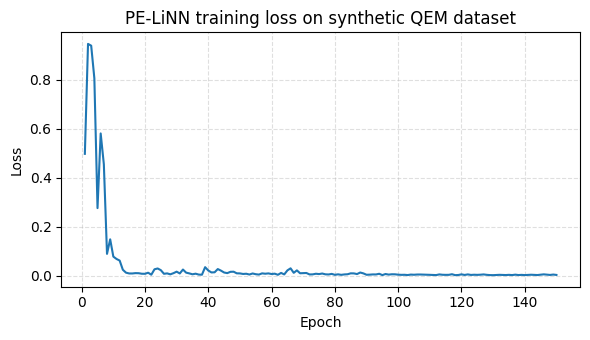

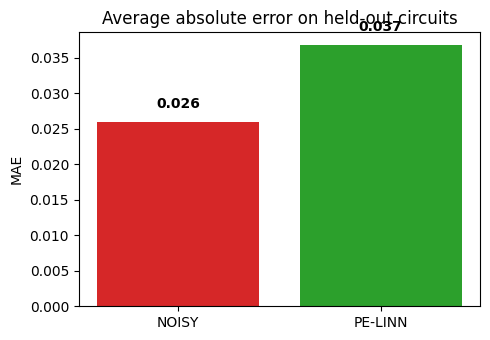

=== Regression metrics (lower is better) ===
   NOISY | MAE: 0.02596 | RMSE: 0.03256 | MAX|err|: 0.06934
 PE-LINN | MAE: 0.03674 | RMSE: 0.05614 | MAX|err|: 0.18666
First few predictions (idx, circuit id, noisy, PE-LiNN, ideal, abs err):
#00 cid=35 noisy= 0.02637 pelinn= 0.00450 ideal=-0.02344 |err|= 0.02794
#01 cid=21 noisy=-0.01807 pelinn=-0.01419 ideal=-0.00195 |err|= 0.01224
#02 cid=39 noisy= 0.00830 pelinn=-0.00795 ideal= 0.04688 |err|= 0.05482
#03 cid=35 noisy= 0.01611 pelinn=-0.00450 ideal=-0.02344 |err|= 0.01894
#04 cid=29 noisy= 0.00195 pelinn=-0.00334 ideal= 0.04297 |err|= 0.04631
#05 cid=18 noisy=-0.00537 pelinn=-0.00221 ideal=-0.03906 |err|= 0.03685
#06 cid=09 noisy= 0.00293 pelinn=-0.00744 ideal=-0.01758 |err|= 0.01014
#07 cid=15 noisy=-0.00732 pelinn=-0.00885 ideal=-0.06445 |err|= 0.05560


In [3]:

import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(6, 3.5))
plt.plot(range(1, len(loss_out) + 1), loss_out)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PE-LiNN training loss on synthetic QEM dataset")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Compare MAE between noisy outputs and PE-LiNN predictions
labels = list(metrics.keys())
mae_values = [metrics[name][0] for name in labels]
plt.figure(figsize=(5, 3.5))
plt.bar(labels, mae_values, color=["tab:red", "tab:green"])
for i, v in enumerate(mae_values):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", fontweight="bold")
plt.ylabel("MAE")
plt.title("Average absolute error on held-out circuits")
plt.tight_layout()
plt.show()

print("=== Regression metrics (lower is better) ===")
for name, (mae, rmse, max_abs) in metrics.items():
    print(f"{name:>8} | MAE: {mae:.5f} | RMSE: {rmse:.5f} | MAX|err|: {max_abs:.5f}")

print("First few predictions (idx, circuit id, noisy, PE-LiNN, ideal, abs err):")
for row in preview_rows[:8]:
    print(
        f"#{row['idx']:02d} cid={row['cid']:02d} "
        f"noisy={row['noisy']: .5f} pelinn={row['pelinn']: .5f} "
        f"ideal={row['ideal']: .5f} |err|={row['abs_err']: .5f}"
    )


In [4]:
# scripts/train_pelinn.py
import sys
# Allow notebooks to import project modules
from pathlib import Path

def _resolve_project_root():
    candidates = []
    try:
        candidates.append(Path.cwd().resolve())
    except FileNotFoundError:
        candidates.append(None)
    if "__file__" in globals():
        candidates.append(Path(__file__).resolve().parent)
    candidates.append(Path("/home/bram/work/PE-LiNN/pelinn-qem"))

    for base in candidates:
        if base is None:
            continue
        if (base / "pelinn").exists():
            return base
        parent = base.parent
        if (parent / "pelinn").exists():
            return parent
    return candidates[-1]

project_root = _resolve_project_root()
if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
import torch, numpy as np, random
from torch.utils.data import Dataset, DataLoader
from pelinn.data.qiskit_dataset import synthesize_samples
from pelinn.model import PELiNNQEM, physics_loss

if ("circuits" not in globals()) or ("observables" not in globals()):
    from qiskit import QuantumCircuit
    from qiskit.quantum_info import SparsePauliOp

    def _default_circuit_family(n=4, m=24):
        cs, obs = [], []
        for _ in range(m):
            qc = QuantumCircuit(n)
            for q in range(n): qc.h(q)
            for q in range(0, n - 1, 2): qc.cx(q, q + 1)
            qc.measure_all(False)  # keep state for estimators
            cs.append(qc)
            obs.append(SparsePauliOp.from_list([("Z" + "I" * (n - 1), 1.0)]))
        return cs, obs

    circuits, observables = _default_circuit_family()

if "noise_grid" not in globals():
    noise_grid = [
        {"p1_depol": 0.001, "p2_depol": 0.01, "p_amp": 0.001, "readout_p01": 0.02, "readout_p10": 0.02},
        {"p1_depol": 0.003, "p2_depol": 0.02, "p_amp": 0.002, "readout_p01": 0.03, "readout_p10": 0.03},
    ]

class QemDataset(Dataset):
    def __init__(self, samples):
        self.X = np.stack([s.x for s in samples]).astype(np.float32)
        self.y = np.array([s.y_ideal for s in samples], dtype=np.float32)
        self.cid = np.array([id(s.meta["qc"]) for s in samples], dtype=np.int64)  # circuit id for grouping
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i], self.cid[i]

def make_groups(cids):
    # group indices sharing the same circuit id
    groups = {}
    for i, c in enumerate(cids): groups.setdefault(int(c), []).append(i)
    return list(groups.values())

def train(model, loader, opt, device="cpu"):
    model.train()
    for X, y, cid in loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        groups = make_groups(cid.tolist())
        loss = physics_loss(pred, y, groups, alpha_inv=0.1)
        opt.zero_grad(); loss.backward(); opt.step()

# usage sketch
def synthesize_training_samples(circuits, observables, noise_grid):
    return synthesize_samples(circuits, observables, noise_grid)

required_symbols = ("circuits", "observables", "noise_grid")
_missing = [name for name in required_symbols if name not in globals()]
if _missing:
    samples = []
    print(f"Missing variables required to synthesize training data: {', '.join(_missing)}")
else:
    samples = synthesize_training_samples(circuits, observables, noise_grid)
#ds = QemDataset(samples); dl = DataLoader(ds, batch_size=128, shuffle=True)
# model = PELiNNQEM(in_dim=ds.X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
# opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
# for epoch in range(100): train(model, dl, opt)


In [5]:
ds = QemDataset(samples); dl = DataLoader(ds, batch_size=128, shuffle=True)
model = PELiNNQEM(in_dim=ds.X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
for epoch in range(100): train(model, dl, opt)


In [6]:
epoch

99